In [38]:
import os
import os.path as path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import anonymize_data, patients_data, get_markers, extract_data

SUGGESTED_MARKERS = {"C7", "REP", "RUL", "RASIS", "RPSIS", "RCA", "RGT",
                     "RLE", "RCA", "RFM", "RA", "LEP", "LUL", "LASIS",
                     "LPSIS", "LCA", "LGT", "LLE", "LFM", "LA"}

## Make data anonymous

In [3]:
# WARNING: this actually renames the original folders and files, make sure you have a backup of the data.
# WARNING: this doesn't make data completely anonymous, as some fields in the c3ds still contains the patients info
# This should at least avoid printing the patients name in notebooks output
# and make them readable in the repository history.
anonymize_data()

# TODO: there are some copies in the original files, remove them

## Evaluate suggested markers sample coverage

In [4]:
diffs = {}

for reader, _, _, _ in patients_data():

    markers = get_markers(reader)
    diff = len(SUGGESTED_MARKERS.difference(markers))

    if diff not in diffs:
        diffs[diff] = 1
    else:
        diffs[diff] += 1

diffs = pd.Series(diffs)
print 'Coverage: %d / %d' % (diffs[0], diffs.sum())

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d
Coverage: 1090 / 1142


## Find optimal markers subset (TODO)

In [5]:
rows = []

for reader, _, _, _ in patients_data():

    markers = get_markers(reader)
    rows.append({marker: 1 for marker in markers})
    
df = pd.DataFrame(rows).fillna(0)

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [8]:
marker_freqs = df.sum()

# Use coverage from suggested markers as threshold
best_cols = marker_freqs[marker_freqs >= 1090].index
n_best_cols = len(best_cols)

filtered_df = df[best_cols]

markers_counts = filtered_df.sum(axis=1)
len(markers_counts[markers_counts >= len(best_cols)])

filtered_df = filtered_df[markers_counts >= len(best_cols)]

len(filtered_df)

1071

## Count bad frames, by marker

In [6]:
bad_markers_map = {}

for reader, _, _, _ in patients_data():

    markers = get_markers(reader)

    for frame, points, analog in reader.read_frames():

        bad_markers = np.where(points[:, 4] == -1)[0]
        for marker in bad_markers:
            if marker >= 255:
                # unexpected marker
                continue
                
            if markers[marker] not in bad_markers_map:
                bad_markers_map[markers[marker]] = 1
            else:
                bad_markers_map[markers[marker]] += 1

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [9]:
bad_markers_counts = pd.Series(bad_markers_map)
markers_counts = df.sum()

freq_markers_counts = markers_counts[markers_counts > 1000]
fred_bad_markers_counts = bad_markers_counts[freq_markers_counts.index].fillna(0)
summary_bad_markers = (fred_bad_markers_counts / freq_markers_counts).sort_values()

print summary_bad_markers[SUGGESTED_MARKERS]

# Bad frames seem to be distributed equally, no need to discard any marker

RFM       5.190853
LASIS     9.657498
RGT       7.941541
RUL       7.911552
LA        4.293700
LFM       6.787852
C7       10.283528
REP       6.453562
RASIS     9.879326
RPSIS     7.370896
LEP       4.616983
RLE       7.050176
LLE       6.441021
LCA       6.411609
LPSIS     7.480923
LUL       5.828365
RCA       6.260334
LGT       7.590788
RA        3.967169
dtype: float64


## Analyze graphs (TODO)

In [10]:
data = extract_data('0', '1')
print 'Extracted', len(data), 'rows'
df = pd.DataFrame(data, columns=['class', 'patient', 'file', 'frame', 'marker', 'x', 'y', 'z', 'bad'])

Reading class 0
Extracted 1807240 rows


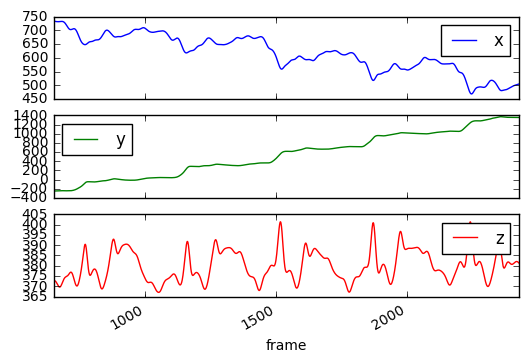

In [11]:
df[(df.marker == 'LFEO') & (df.file == '1_1.c3d')]\
    .sort_values('frame').plot('frame', ['x', 'y', 'z'], subplots=True, sharey=False)
plt.show()

## Position boundaries

In [23]:
rows = []

patients_iterator = patients_data()
for reader, class_folder, patient_folder, patient_file in patients_iterator:
    markers = get_markers(reader)
    
    # (marker, x|y|z, min|max)
    bounds = np.zeros((len(markers), 3, 2))
    bounds[:, :, 0] = 10e10
    bounds[:, :, 1] = -10e10

    for frame, points, analog in reader.read_frames():
        
        # The 255 limit is to prevent unexpected markers in 59_1.c3d and 59_2.c3d
        bounds[:, :, 0] = np.fmin(bounds[:, :, 0], points[:255, 0:3])
        bounds[:, :, 1] = np.fmax(bounds[:, :, 1], points[:255, 0:3])
        
        '''for marker, point in enumerate(points):
            if marker >= 255:
                # skip unexpected markers
                continue
            
            bounds[marker][0][0] = min(point[0], bounds[marker][0][0])
            bounds[marker][1][0] = min(point[1], bounds[marker][1][0])
            bounds[marker][2][0] = min(point[2], bounds[marker][2][0])
            
            bounds[marker][0][1] = max(point[0], bounds[marker][0][1])
            bounds[marker][1][1] = max(point[1], bounds[marker][1][1])
            bounds[marker][2][1] = max(point[2], bounds[marker][2][1])'''

    all_min = np.min(bounds[:, :, 0], axis=0)
    all_max = np.max(bounds[:, :, 1], axis=0)

    rows.append([
        class_folder,
        patient_folder,
        patient_file,
        #bounds
        all_min[0],
        all_max[0],
        all_min[1],
        all_max[1],
        all_min[2],
        all_max[2]
    ])
    
# Generate DataFrame with summary data
df_bounds = pd.DataFrame(rows, columns=[
    'class', 'patient', 'file', 
    'min_x', 'max_x',
    'min_y', 'max_y',
    'min_z', 'max_z'
])

Reading class 0
Reading class 1
Reading class 2
Reading class 3
Error reading 114_8.c3d


In [35]:
df_bounds.patient = pd.to_numeric(df_bounds.patient)
df_bounds.head(5)

,class,patient,file,min_x,max_x,min_y,max_y,min_z,max_z
0,0,1,1_1.c3d,-297.186127,1644.620728,-695.424316,2152.603516,-184.325119,1233.257568
1,0,1,1_2.c3d,-419.700409,1890.699829,-294.114838,1624.078003,-191.920547,1215.907837
2,0,1,1_3.c3d,-1336.119385,684.095520,-70.693817,2777.613770,-186.695572,1206.898682
3,0,1,1_4.c3d,-73.822647,2413.872559,-72.171555,2494.879150,-202.915039,1207.077881
4,0,1,1_5.c3d,-594.534241,1515.198975,-299.986816,2062.800293,-1893.749146,1848.347778


In [37]:
print 'x: (%.2f, %.2f)' % (df_bounds.min_x.min(), df_bounds.max_x.max())
print 'y: (%.2f, %.2f)' % (df_bounds.min_y.min(), df_bounds.max_y.max())
print 'z: (%.2f, %.2f)' % (df_bounds.min_z.min(), df_bounds.max_z.max())

x: (-48837.12, 20959.00)
y: (-66751.12, 93043.75)
z: (-33777.16, 46231.46)
